## Moneyball and the Birth of Modern Baseball Analytics

# A game rewritten by data

In 2001, the Oakland Athletics finished the regular season with 102 wins and 60 losses, tied for the second-best record in Major League Baseball. It was the first 100-win season for the franchise since 1990. The team had three future Cy Young-level pitchers — Tim Hudson, Mark Mulder, and Barry Zito — forming the famed “Big Three” rotation. Their offense was led by Jason Giambi, the American League MVP in 2000, who mashed 38 home runs. Johnny Damon, acquired in a three-team deal, brought speed and leadoff explosiveness. Miguel Tejada drove in 113 runs from shortstop. The team was stacked. Still, that did not matter. The A’s lost in the AL Division Series to the New York Yankees, blowing a 2–0 series lead. After the season ended, the A's began to lose talent.

* Jason Giambi signed a \$120 million deal with the Yankees.
* Johnny Damon went to the Red Sox.
* Jason Isringhausen, their All-Star closer, left for the Cardinals.

Oakland could not match the offers nor the budget of the bigger teams. The
front office, led by Billy Beane, faced a hard truth: **They could build a great
team, but could not afford to keep one.** The 2001 offseason forced Beane
to take a new approach. He turned to Paul DePodesta, a Harvard graduate
and former football player who had a background in economics and statistics.
Together, they began identifying undervalued players, often those with high on-
base percentages (OBP), who traditional scouts overlooked because they did
not look the part or swing like stars.

Fast forward to today, the story of Moneyball¹ has become a landmark not
only in baseball, but also in sports analytics in general. Moneyball was not just about baseball. It was about thinking differently, asking better questions, and using data to uncover value where others had overlooked it. In recent years, Billy Beane has even taken the philosophy beyond baseball, applying it to new markets like professional soccer².

In this chapter, we will walk you through how a few simple regression models, built in Python, can explain the Moneyball revolution and teach the fundamentals of baseball analytics.

¹The term ”Moneyball” was popularized by Michael Lewis in his 2003 book **Moneyball: The Art of Winning an Unfair Game**, which chronicled Billy Beane’s data-driven approach to building a competitive baseball team. The story was later adapted into the 2011 film Moneyball, starring Brad Pitt as Billy Beane.
²O’Hanlon, Ryan, Moneyball works too well: Why Milan and Toulouse are proof soccer’s analytics era is here, ESPN, May 14, 2024. Retrieved from https://www.espn.com/soccer/insider/story/_/id/38728748 milan-toulouse-moneyball-works-too-well-uefa

# Exploring the Data Behind the Moneyball Philosophy

To better understand the logic behind the Moneyball philosophy, we will work with a dataset that contains Major League Baseball team statistics ranging from 1962 to 2012. However, before loading any data into a Python integrated development environment (IDE), it is always a good practice to skim through the data to get an idea of what lies ahead. So, go ahead and open the baseball.csv file and check the data structure and column names before returning to this text.

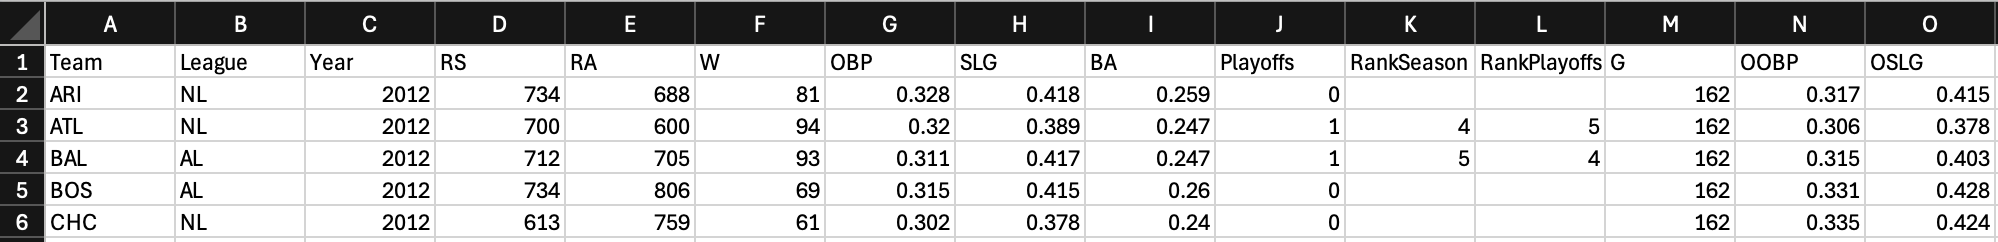
**Figure 1:** First few rows of the ’baseball.csv’ dataset

As you were able to notice, the dataset contains one row per team per season,
with variables like:

* Team – team abbreviation (e.g., ARI, ATL)
* League – league name (AL or NL)
* Year – season year
* RS – runs scored by the team
* RA – runs allowed by the team
* W – number of wins
* OBP – on-base percentage
* SLG – slugging percentage
* BA – batting average
* Playoffs – binary indicator: 1 if the team made the postseason, zero
otherwise
* RankSeason – team’s rank in the regular season
* RankPlayoffs – team’s rank in the playoffs
* G – total games played
* OOBP – opponent on-base percentage
* OSLG – opponent slugging percentage

The observant reader will notice that for the RankSeason column, not all the
teams contain data entries. Also, the OOBP and OSLG columns are only populated
from the 1999 season onwards. In any sports analytics endeavor, it is essential
to verify the integrity of the data being used, as the quality of the data is just as critical as the models and methods that you apply. Now, it is time to load our data into a Python environment. While there are many IDEs available, for this analysis, we will use Google Colaboratory, which requires no local installation and runs in the browser. These are the steps:

1. Head over https://colab.research.google.com/.

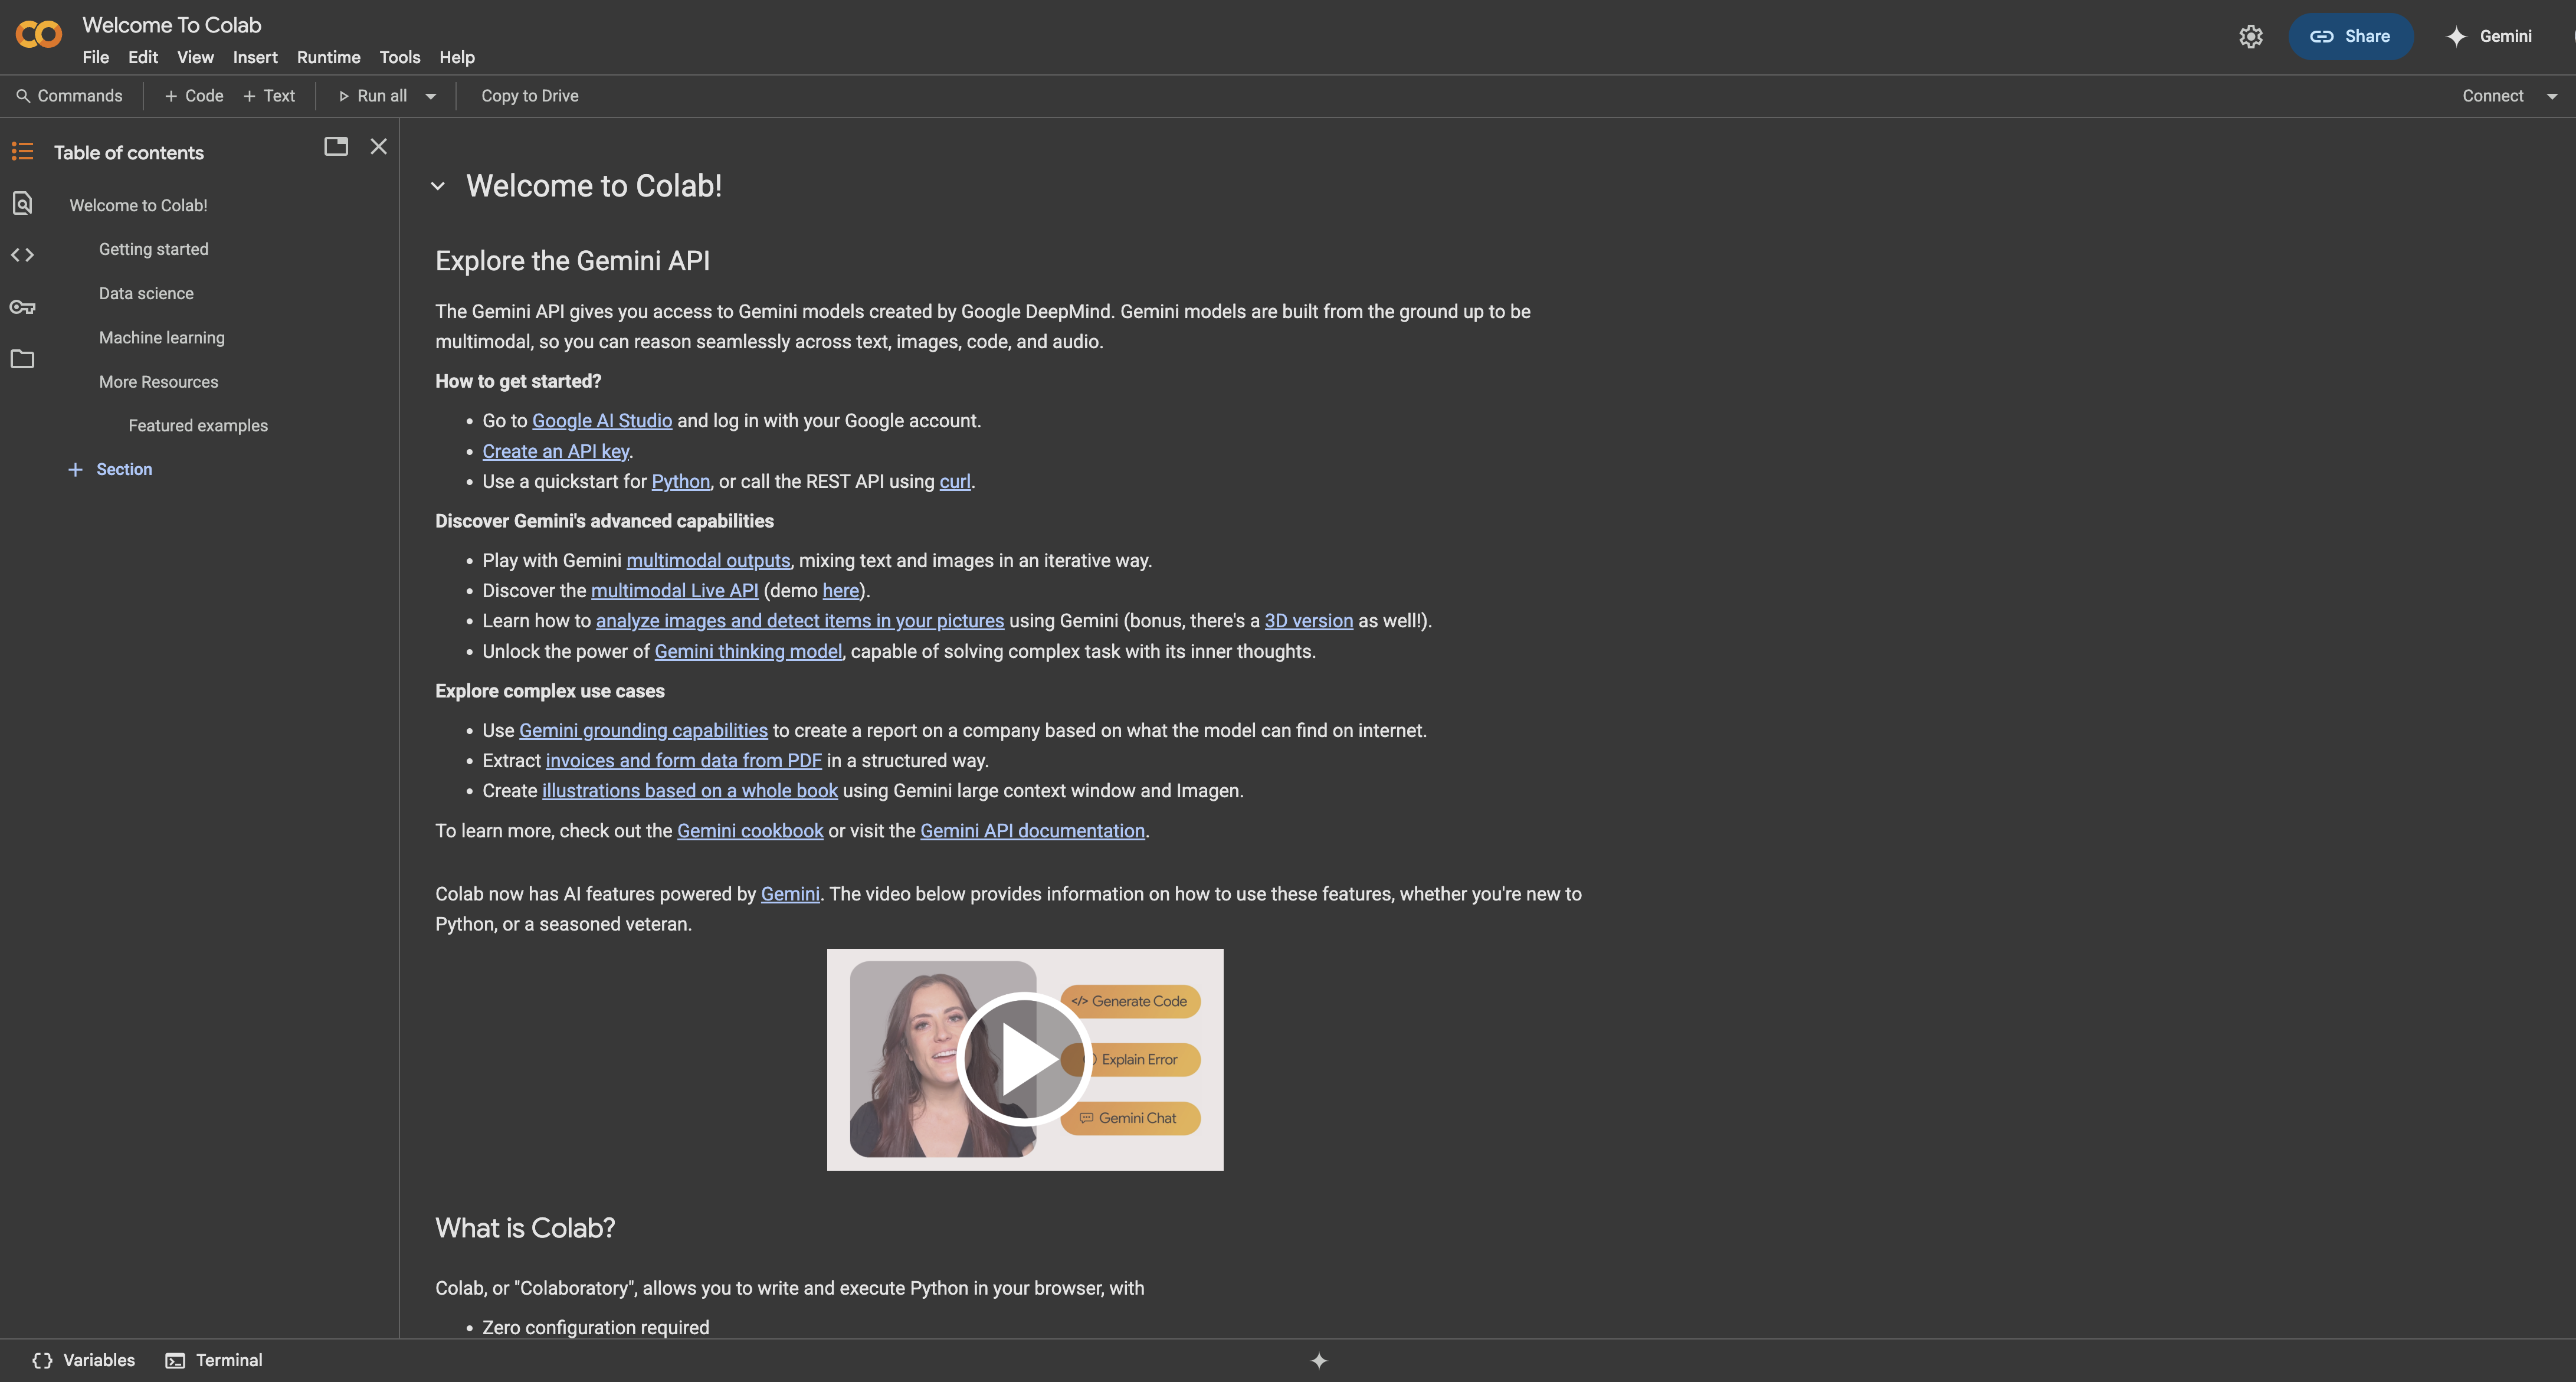
**Figure 2:** Google Colab landing page

2. Click on **“File”** in the right top menu, then select **“New notebook”**.

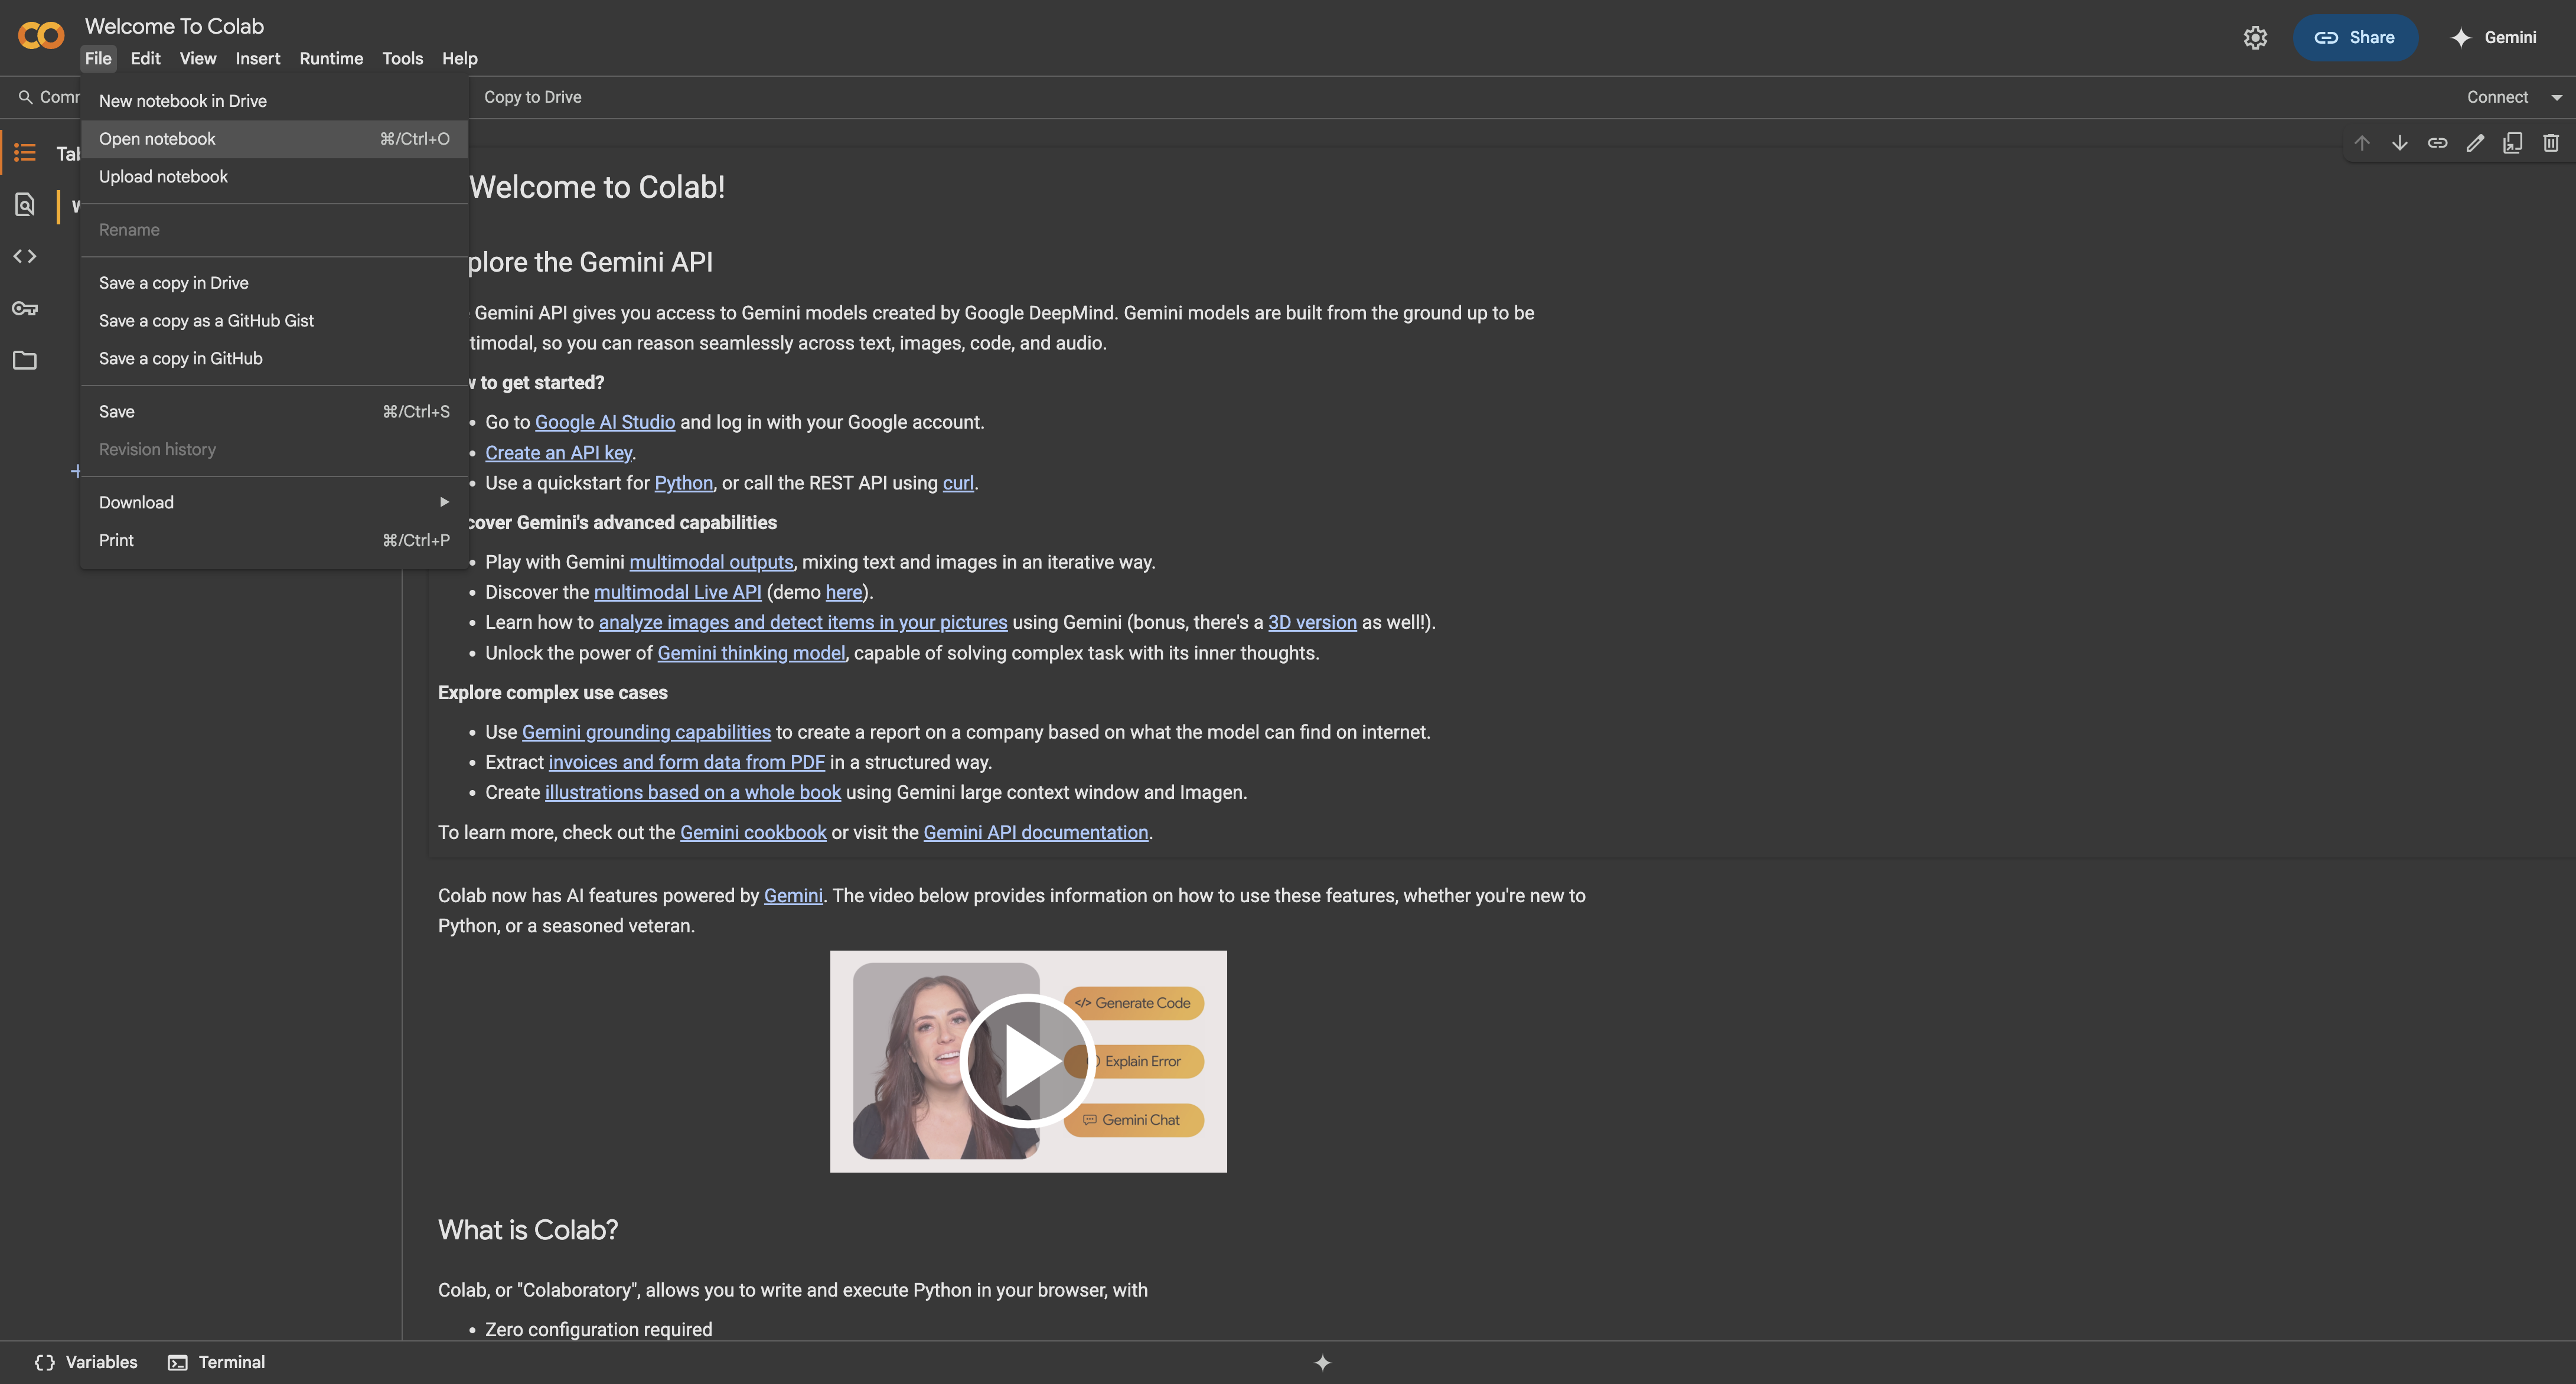
**Figure 3:** Creating a new Colab notebook

3. To upload your dataset (e.g., baseball.csv), click the folder icon on the left sidebar, then click the upload icon and select your file.

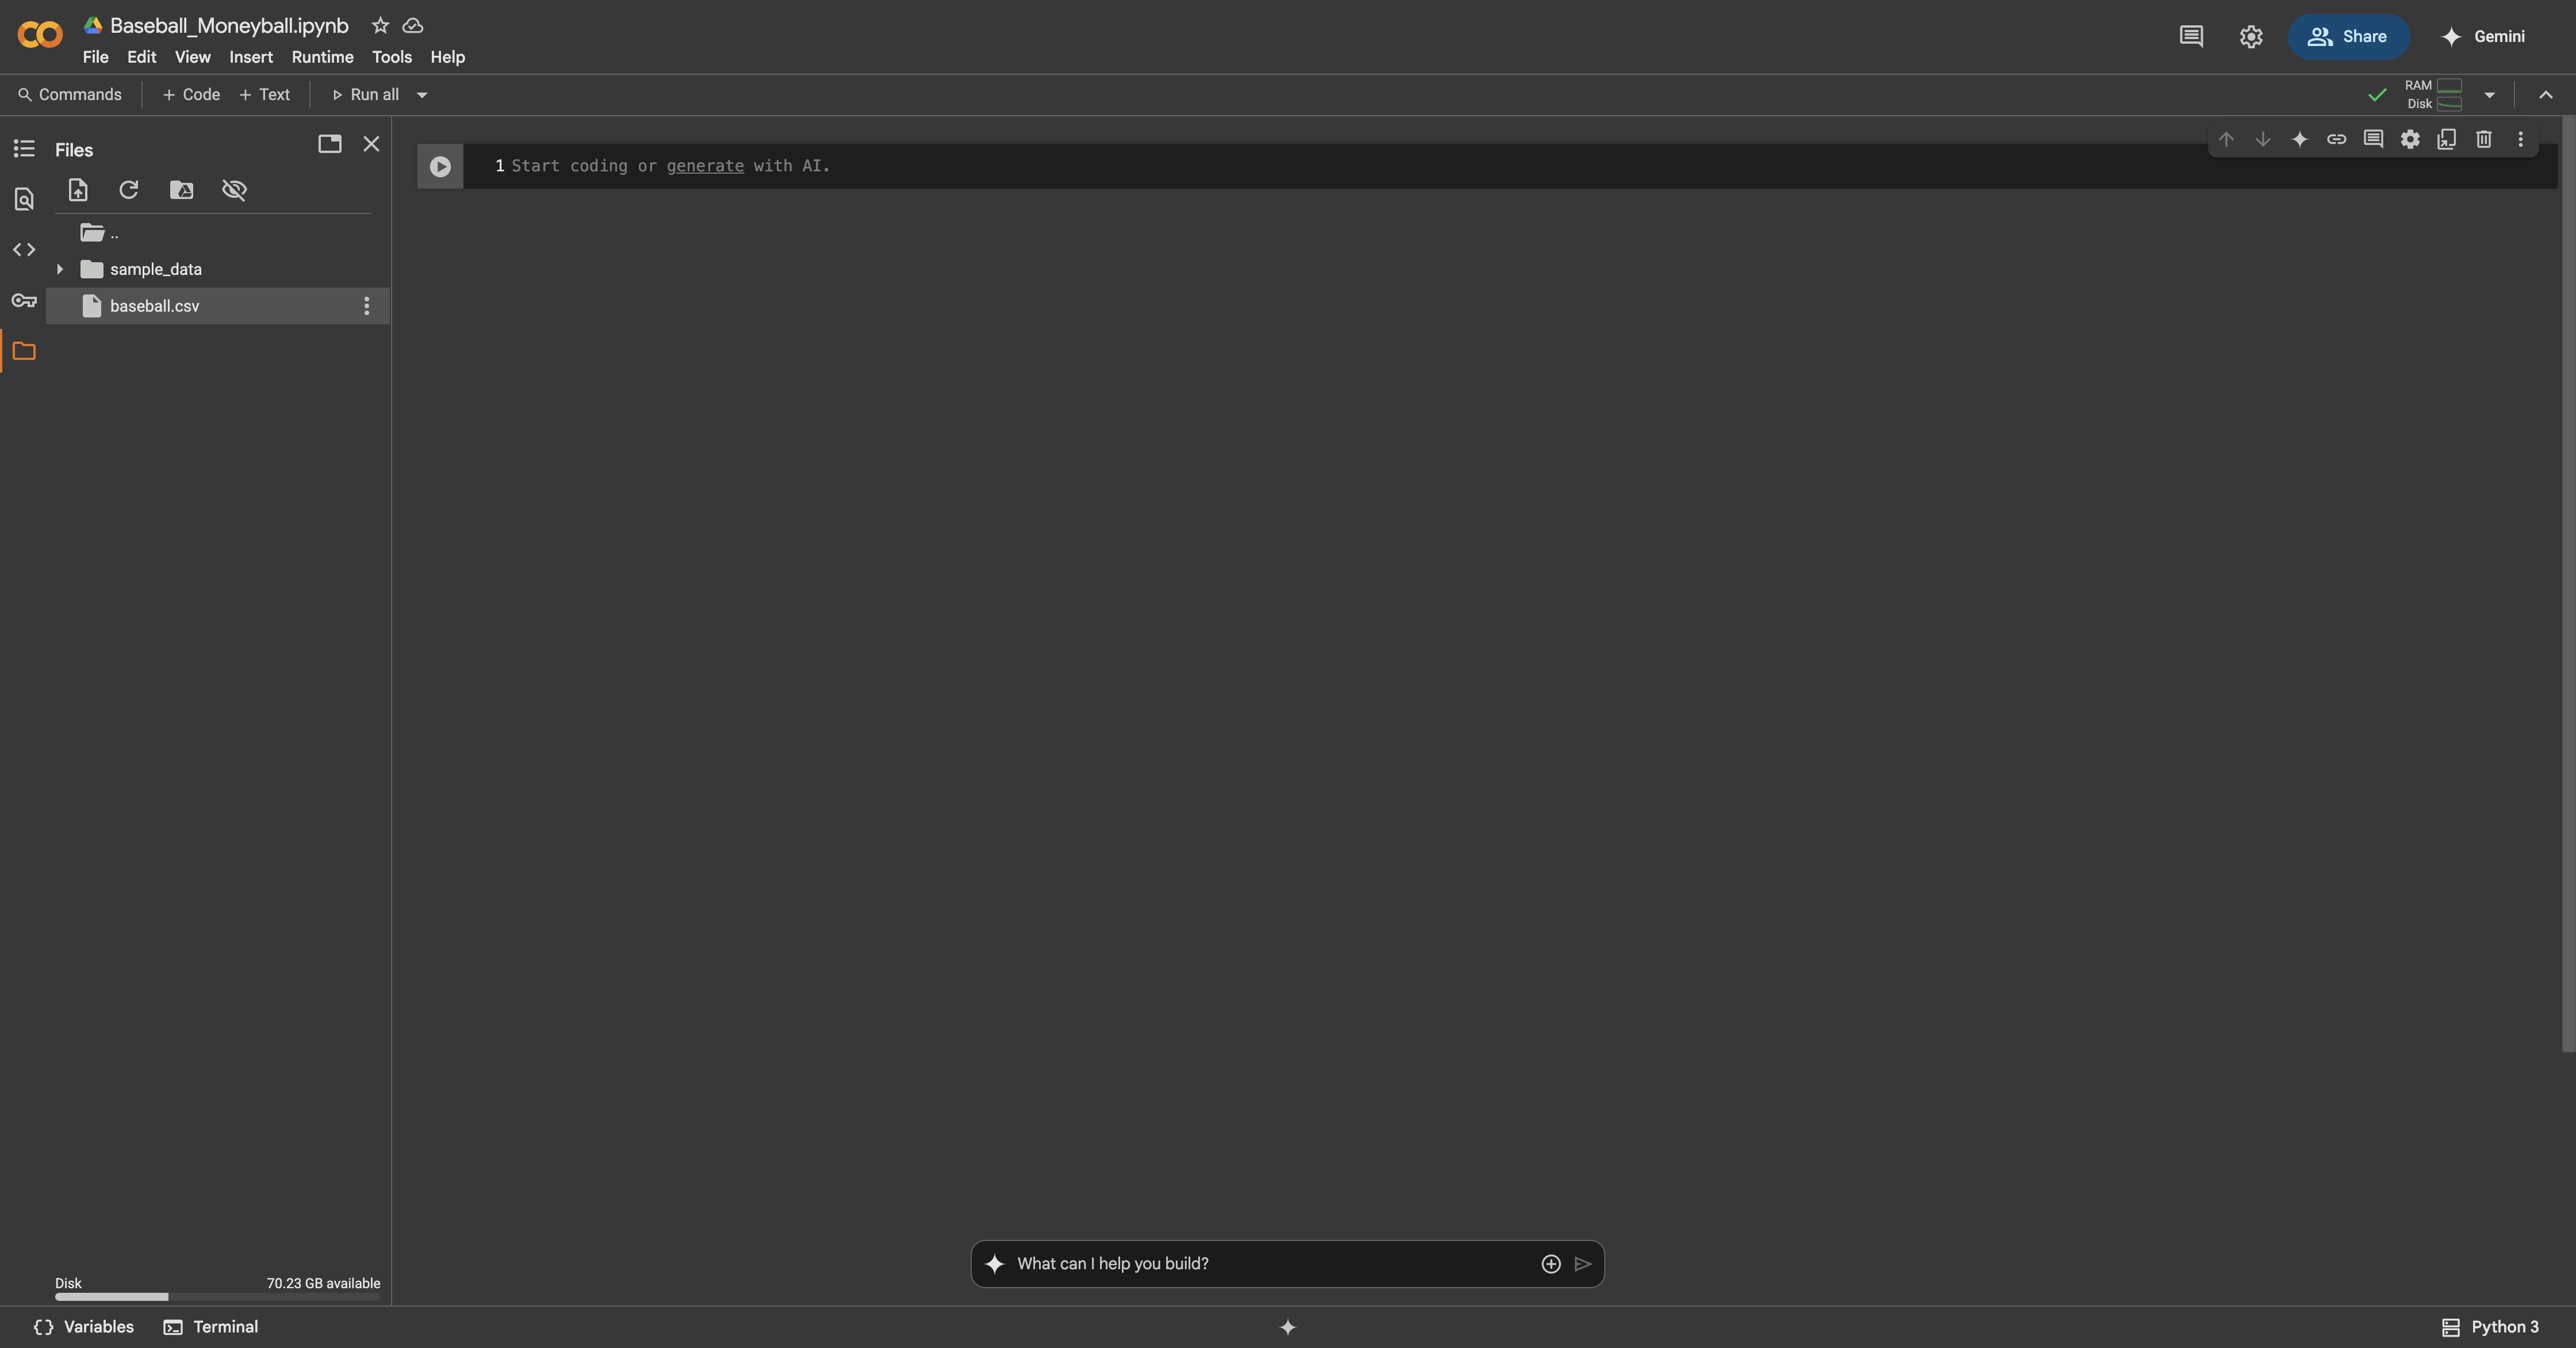
**Figure 4:**Uploading a CSV file to Colab

So far, we have uploaded the file into the environment; still, a few steps are
needed to analyze, manipulate, and perform proper baseball analytics. First,
we need to load the required Python libraries: pandas (imported as pd) for
basic data wrangling and manipulation, statsmodels.formula.api (imported
as smf) for performing linear regression modeling, and matplotlib.pyplot or data visualization. Then, a variable called url is created and the file
baseball.csv is assigned to such variable. Hence, using the pandas method
pd.read csv, we pass the url variable as an argument to that function. This
allows us to read the data in a DataFrame format, which will serve as the core
data structure for all our analysis.

In [ ]:
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# Load the data
url = "baseball.csv"
baseball = pd.read_csv(url)

As previously mentioned, this dataset contains information from 1962 through
2012; however, we will focus the analysis on the period before the Moneyball
years, specifically before the 2002 season. For that reason, we need to filter out our data, and the following line allows us to accomplish that precisely:

In [ ]:
# Subset to Moneyball years (before 2002)
moneyball = baseball[baseball['Year'] < 2002].copy()

What this line of code does is create a new variable called moneyball where we
will store a copy (using the .copy() method) of the result of filtering out the
entire DataFrame with a Boolean filter that returns True for every row where
the year is less than 2002, and False otherwise. Now, the data is clean and
ready to be analyzed and ingested into our models.

## Quantifying Victory: Modeling Wins Through Run Differential

One of the first ideas that we will explore is simple but powerful: Can we
predict how many games a team wins based on their run differential, that is,
the number of runs they scored minus the number of runs they allowed over a
season? Common sense dictates that the probability of winning many games
might be higher if you outscore your opponents on a game-by-game basis, while
having many one-run games reduces the likelihood of winning a lot of games, let
alone having a negative run differential when your opponents stack a lot of runs
against you. Let’s dive into the data to find the answer to this question. First, we do not have a column that directly provides us with each team’s run differential, so we need to create such a column and make the proper calculations.

In [ ]:
# Calculate Run Difference (RD)
moneyball['RD'] = moneyball['RS'] - moneyball['RA']

The line of code above creates a new column called "RD" in our moneyball
DataFrame and for each row subtracts the number of runs allowed "RA" from the
number of runs scored "RS" for each team. This way, we get a clean calculation
of each team’s run differential. Then, we fit a simple linear regression - strictly speaking, an ordinary least squares regression model - using the statsmodels (smf) module’s ols method to see how well the new "RD" column explains the number of wins "W". In other words, we are saying ”wins are a linear function of run differential”, so we are testing whether each additional run a team outscored its opponents translates into a predictable increase in wins. We accomplish this by using the following line of code:

In [ ]:
# Regression model
wins_model = smf.ols('W ~ RD', data=moneyball).fit()

Finally, we create a scatterplot using matplotlib.pyplot to visualize this relationship:

In [ ]:
# Scatterplot
plt.figure(figsize=(10, 6))
plt.scatter(moneyball['RD'], moneyball['W'], alpha=0.7)
plt.plot(moneyball['RD'], wins_model.predict(), color='red', linewidth=2)
plt.title('Wins vs Run Difference')
plt.xlabel('Run Difference (RD)')
plt.ylabel('Wins (W)')
plt.grid(True)
plt.show()

Here is an explanation of what each line of code does.

* `plt.figure(figsize=(10, 6))` creates a new figure for the plot with a
width and height of 10 and 6 inches, respectively.
* The line of code `plt.scatter(moneyball[’RD’], moneyball[’W’][...]`
instructs to plot the run differential "RD" on the X-axis and wins "W" on
the y-axis. The The alpha=0.7 part makes the points slightly transpar-
ent.
* `plt.plot(moneyball[’RD’], wins model.predict() [...]` creates an
overlay of the regression line using the predicted win values. The ar-
guments `color=’red’, linewidth=2` set the line color to red and the
thickness to 2.
* `plt.title(’Wins vs Run Difference’)` adds a title to the plot.
* `plt.xlabel(’Run Difference (RD)’)` adds an axis label to the X-axis
as ”Run Difference (RD)”.
* `plt.ylabel(’Wins (W)’)` adds an axis label to the y-axis as ”Wins (W)”.
* `plt.grid(True)` adds a grid on the plot, and the last line `plt.show()`
allows to correctly render the plot.

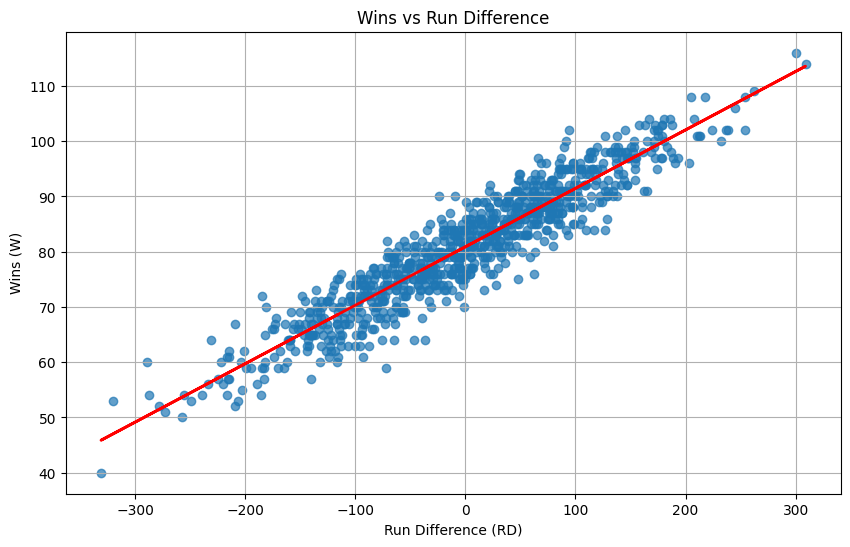

**Figure 5:** Scatterplot of Wins vs. Run Difference with best-fit line

A glance at the scatterplot reveals a strong positive relationship between run
differential and total wins, with the data points aligning closely along a straight line. Let’s turn our attention to the regression results by running the following line of code:

In [ ]:
print(wins_model.summary())

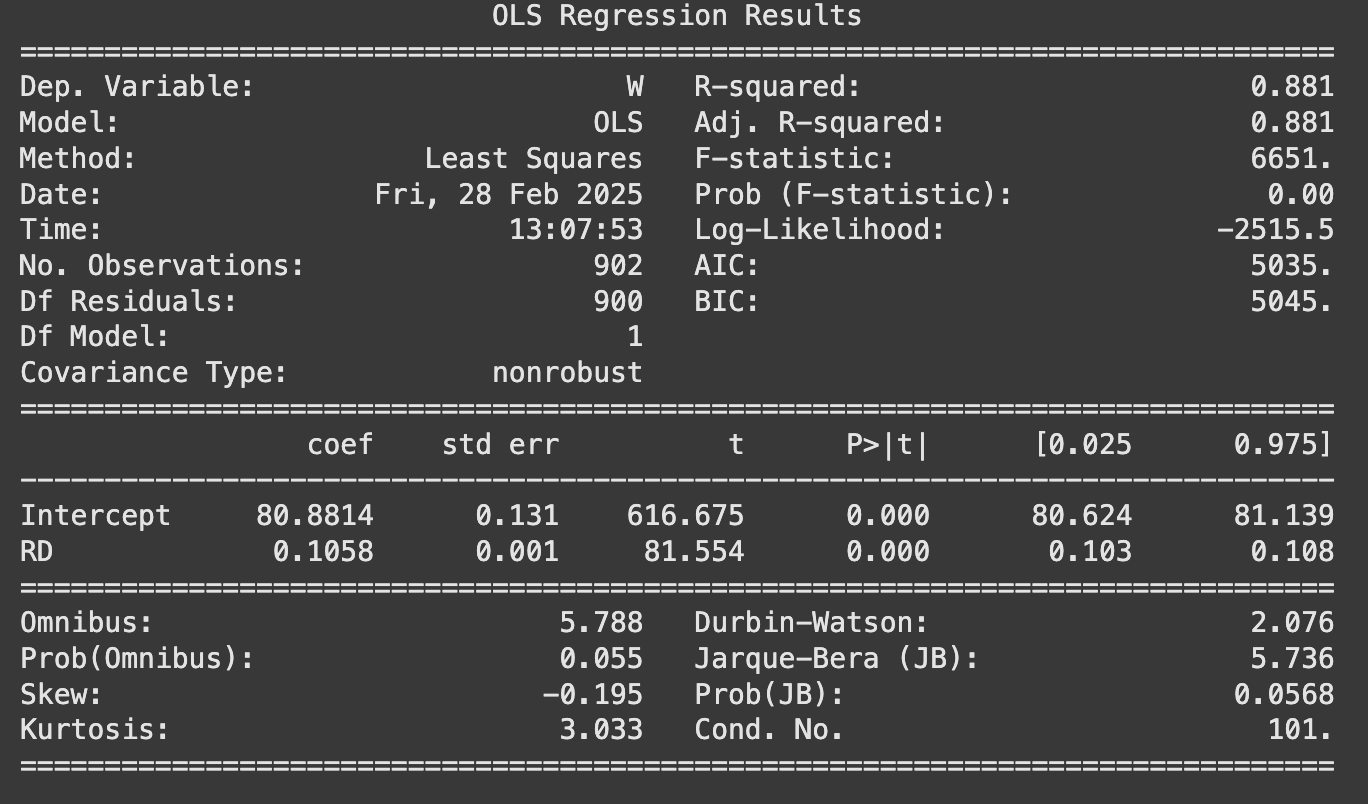

**Figure 6:** OLS regression summary: Wins as a function of Run Differential

The regression results tell us a fascinating story, one that Bean and their team
already discovered many years ago, but remains quite essential today. First,
let’s carefully analyze the *R-squared* score, 0.881, this tells us that around 88.1% of the variation in any team’s wins can be explained by their run differential alone, that is quite a subtantial amount of variance for a single variable and this denotes the importance of optimizng run differential for any MLB team. Taking a close look at the regression coefficients, the `Intercept` scored 80.88, which is the model’s predicted baseline number of wins when the run differential equals zero. The coefficient for the `"RD"` variable is 0.1058, which can be interpreted as for every additional run in a team’s run differential, a team is expected to win approximately 0.106 more games. In other words, ten extra runs in a team’s run differential equate to an additional win over a season.

The *p-values* for both the `Intercept` and `"RD"` are 0.000, which means the relationship is highly statistically significant. A *p-value* of less than 0.005 is considered statistically significant. Still, in our case, there is clear evidence that these variables capture a substantial amount of signal from the data. Finally, another metric to look at is the confidence intervals, especially for the `"RD"` variable, as the 95% confidence interval is [0.103, 0.108], meaning we’re highly confident the actual impact of one run is in that range.

Picture yourself for a second knowing this information in the early 2000s, working inside an MLB front office. It would be a gold mine, and for Billy Bean and his team, it was as they capitalized on this edge quickly, gaining a strategic advantage over most, if not all, of the league. For this reason, this might be the essence of the Moneyball mindset: not just guessing that run differential matters, but quantifying how much and by what degree it matters, backed by data. More importantly, perhaps, it is about knowing how to build and optimize a roster to maximize their run differential and convert it into more wins.

In baseball analytics, it is crucial to understand that there are many methods
and ways to find answers to the same problem. Hence, what if, instead of using
a team’s run differential, we estimate how many games that team should have
won based on how many runs they allowed and scored? That is the topic that
we will cover in the following section, which allows us to see not only what
happened, but what ought to have happened.

## The Bill James Approach

The previous model relied solely on the run differential to predict wins. This
time, we will model how many wins a team should have earned based on each
team’s offensive and defensive contributions. For this, we will revisit one of the earliest and most influential models in *sabermetrics*³: **Pythagorean Expectation**. Baseball statistician Bill James developed this approach in the early 1980s in his *Baseball Abstracts*⁴ in an attempt to predict a team’s expected wins. Inspired by the Pythagorean theorem in geometry - hence the name - James proposed the following formula:

$\text{Expected Wins} = \frac{RS^2}{RS^2 + RA^2} \times G$

Where:
* RS – Runs Scored
* RA – Runs Allowed
* G – Games Played

³Society for American Baseball Research (SABR), What is Sabermetrics?, Retrieved from https://sabr.org/sabermetrics

⁴James, Bill, The Bill James Baseball Abstract 1981, Ballantine Books, 1981.

This formula provides a team’s expected wins based on the proportion of runs in
its games. The reason behind squaring the terms is that it allows for amplifying
the gap between strong and weak teams, and then scales to the number of games
played. This approach is better aligned with observed win patterns than most
linear models. Now, in the previous chapter, we took our time to review every
piece of code and provide explanations of its logic. However, for this section, we will take a more streamlined approach, focusing on the core ideas and reasoning behind the code to maintain momentum and accelerate our progress. The first step will be to apply the Pythagorean Expectation formula:

In [ ]:
moneyball['EW'] = (moneyball['RS'])**2/((moneyball['RS']**2 + moneyball['RA']**2))*moneyball['G']

This line of code creates a new column called `"EW"`, short for Expected Wins,
and squares for each team their number of runs scored (`"RS"`) and divides over
the same term plus the squared of their runs against (`"RA"`). The number of
games played scales the result of these operations; usually, but not for all teams in all seasons, 162 games. Now that we have created that new column that
contains the expected wins for each team, we proceed to fit a simple linear
regression with wins (`"W"`) as the target variable and expected wins `"EW"` as the single predictor.

In [ ]:
wins_model_bj = smf.ols('W ~ EW', data=moneyball).fit()

Once again, we visualize the result using a scatterplot and best-fit line:

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(moneyball['EW'], moneyball['W'], alpha=0.7)
plt.plot(moneyball['EW'], wins_model_bj.predict(), color='red', linewidth=2)
plt.title('Wins vs Expected Wins (Bill James)')
plt.xlabel('Expected Wins (Bill James)')
plt.ylabel('Wins (W)')
plt.grid(True)
plt.show()

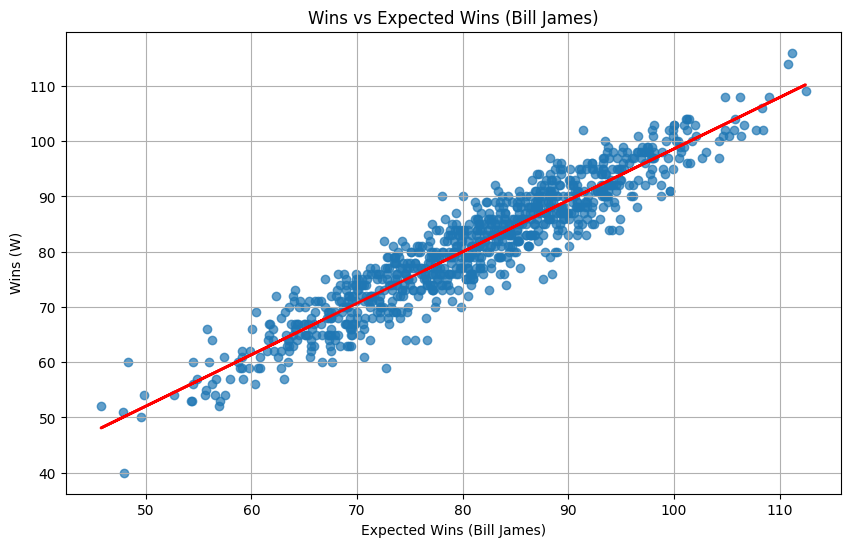

**Figure 7**: Scatterplot of Wins vs. Expected Wins with best-fit line

By analyzing the plot, we observe a nearly linear relationship: teams with higher expected wins generally tend to have more actual wins, although not always consistently. So why is this insight valuable in baseball analytics? At its core, this modeling technique helps mitigate the role of luck in team performance. A team that significantly outperforms its expected wins may simply be benefiting from variance, for example, by winning one-run games. In contrast, a team that underperforms its expected wins might be better than its record suggests. For a front office, this discrepancy can be critical. If a team fell short of its expected win total, it can point to bad luck or reveal specific weaknesses, such as bullpen instability or poor situational hitting, that need to be addressed. On the other hand, if a team exceeded expectations, it could be a sign of overperformance that is unlikely to repeat in the future without structural adjustments. Lastly, let’s check the regression results for more insights:

In [ ]:
print(wins_model_bj.summary())

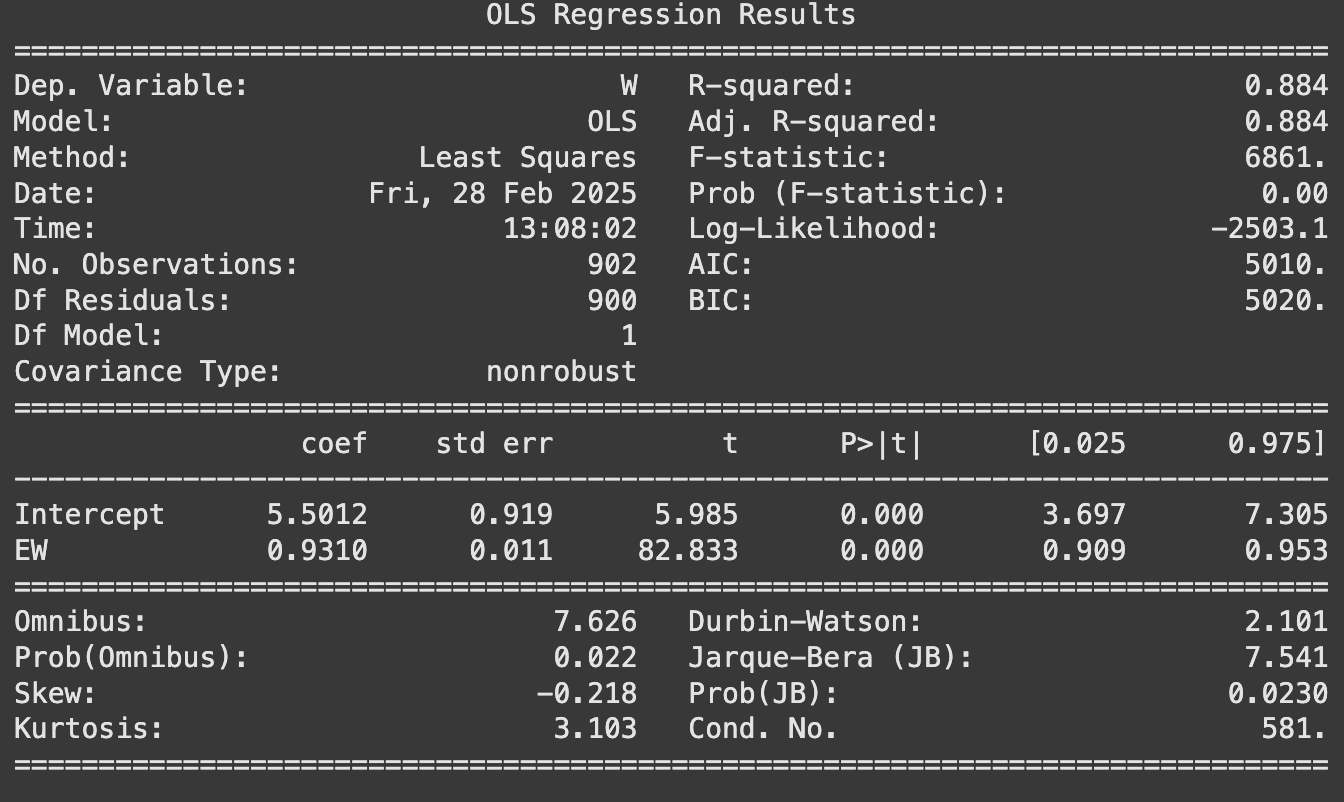

**Figure 8**: OLS regression summary: Wins as a function of Expected Wins

The *R-squared* is 0.884. Hence, 80.4% of the variance in a team’s wins (`"W"`) can be explained solely by the Pythagorean Theorem or their expected wins (`"EW"`), once again, a high proportion of variance. In this model, the coefficients are a little bit harder to read. The `"Intercept"` scored 5.50, which is the baseline number of wins when the predicted wins equal zero. This has no real-world application, as no team ever has zero expected wins. The coefficient for (`"EW"`) of 0.9310 suggests that for every additional expected win, a team is predicted to earn about 0.93 actual wins, a lower number than an actual win that reflects natural variation due to luck and other variables. The *p-values* for both the `"Intercept"` and `"EW"` are highly statistically significant with a score of 0.000. Lastly, the confidence intervals for the `"EW"` variable of [0.909, 0.953] tell us that with a 95% confidence, a unit increase in expected wins lies between 0.909 and 0.953 actual wins.

The Pythagorean Theorem, as popularized by Bill James, provides a solid
foundation in baseball analytics, although it is not perfect. In recent years, other researchers have refined this approach and developed more effective solutions⁵. Now that we have explored these two broad approaches, we will delve into a more granular analysis, shifting our attention to the team’s offensive and defensive outputs.

⁵Silver, Nate, A New Formula to Predict a Team’s Winning Percentage, Society for American Baseball Research (SABR), Fall 2003. Retrieved from https://sabr.org/journal/article/a-new-formula-to-predict-a-teams-winning-percentage/

## Dissecting Offensive and Defensive Output: Why OBP and SLG Matter Most?

The next matter of business is depicting what drives a team’s ability to score runs. Old-school baseball wisdom would argue that a batter’s offensive output
is solely determined by their batting average or runs batted in, but that was
precisely what Billy Bean and their team defied. Instead of following mainstream precepts, they utilized metrics such as on-base percentage (OBP) - the percentage of times a team’s batters get on base - and slugging percentage (SLG) - the percentage of times a team’s batters hit for power - to identify undervalued players. Although these metrics were already established in MLB decades before Billy Bean’s stint in the A’s front office and popularized by people like Bill James, OBP in particular was famously undervalued, and the Oakland A’s front office took advantage of this inefficiency as part of their strategy. To test the relevance of OBP and SLG concerning run production, we will run a multiple linear regression with Runs Scored (RS) as a function (~) of OBP and SLG.

In [ ]:
# Regression model (using OBP + SLG)
rs_model = smf.ols('RS ~ OBP + SLG', data=moneyball).fit()

The line of code above fits a multiple linear regression with OBP and SLG as the
predictor variables and RS as the response variable. Since we are now using two
predictors instead of one, hence the name multiple regression instead of simple,
it may be complicated to visualize the plot for this model in a three-dimensional space. Therefore, we will bypass that step and proceed directly to reviewing the regression results.

In [ ]:
print(rs_model.summary())

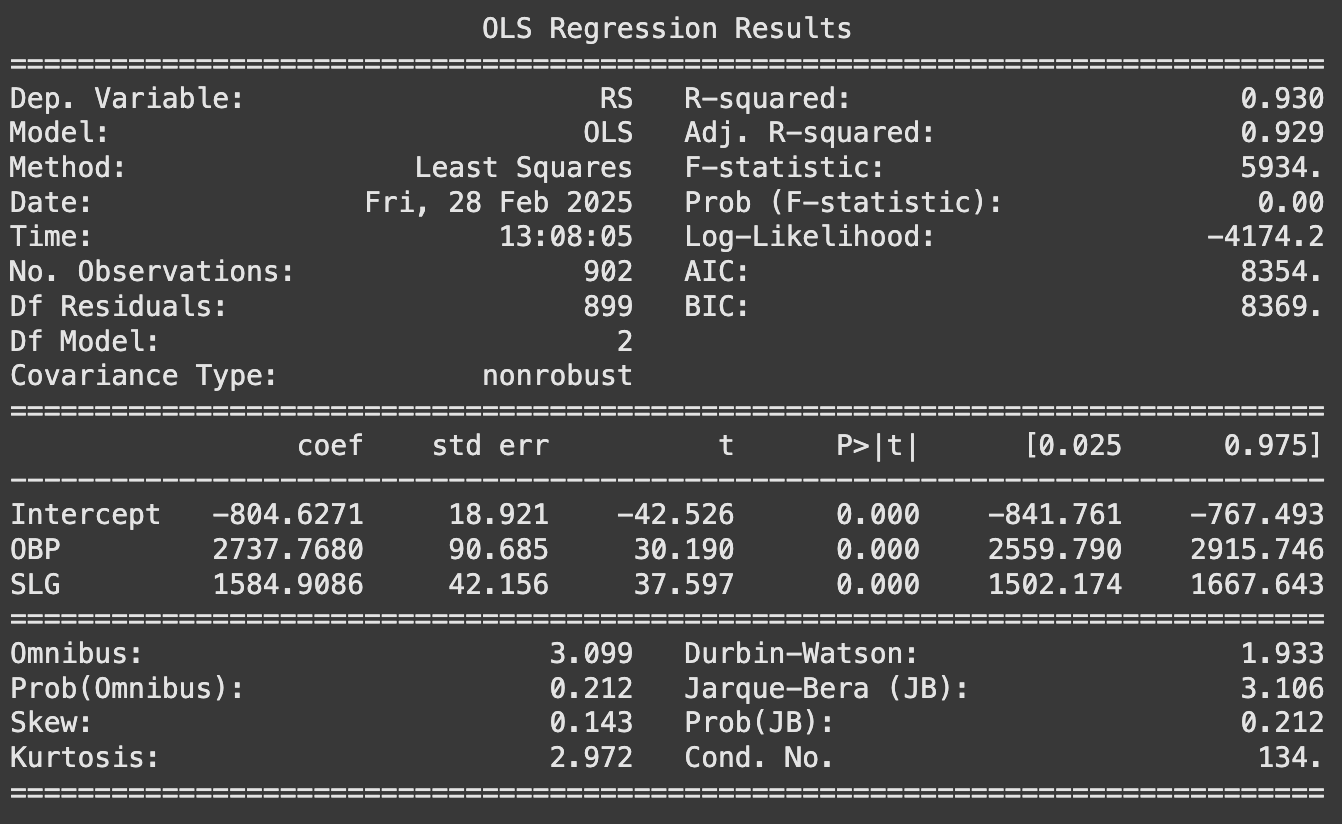

**Figure 9**: OLS regression summary: Runs Scored as a function of OBP and SLG

The regression results are compelling once again; the *R-squared* value sits at 0.930, but in this case, since we are using more than one predictor variable, we need to use the *Adjsuted R-squared* as the evaluation metric since it penalizes the model by the number of predictor variables that are utilized. Hence, 92.9% of the variance in runs scored can be explained just by SLG and OBP. Only 7% of run production is left unexplained. Once again, in this model, the `Intercept` does not carry a real-world application nor interpretation; then we have the coefficients for both OBP and SLG of 2727.76 and 1584.90 for each variable respectively, remember that these coefficients are framed for each team in a season. To make the coefficients more interpretable, let’s scale them. If a team’s OBP increased by a whole unit (e.g., from 0.000 to 1.000), they would theoretically score 2,737 more runs. That’s unrealistic — no team has an OBP of 1.000 — but it gives us a useful baseline. Instead, let’s consider a more practical scenario, such as increasing from an OBP of 0.330 to 0.340, which is a 0.010 or one percentage point increase. Then, we multiply the coefficient by 0.010:

$2737.77 \times 0.010 = 27.38$

So, a 0.010 increase in OBP is associated with about 27.38 more runs per season
**under the assumption that SLG remains constant**. Now, let’s review the
same logic but for SLG:

$1584.91 \times 0.010 = 15.85$

This means that a one-point increase in SLG leads to approximately 15.85 more
runs, assuming that OBP remains constant. The *p-values* for both OBP and SLG are highly statistically significant, and the 95% confidence intervals are very
tight. For the sake of clarity, let’s see what happens to our model if we add
batting average as a predictor variable of Runs Scored.

In [ ]:
# Regress BA in addition to SLG and OBP to demonstrate that BA is not very important
rs_model_BA = smf.ols('RS ~ OBP + SLG + BA', data=moneyball).fit()
print(rs_model_BA.summary())

The only modification to our previous model is the inclusion of the BA predictor
variable.

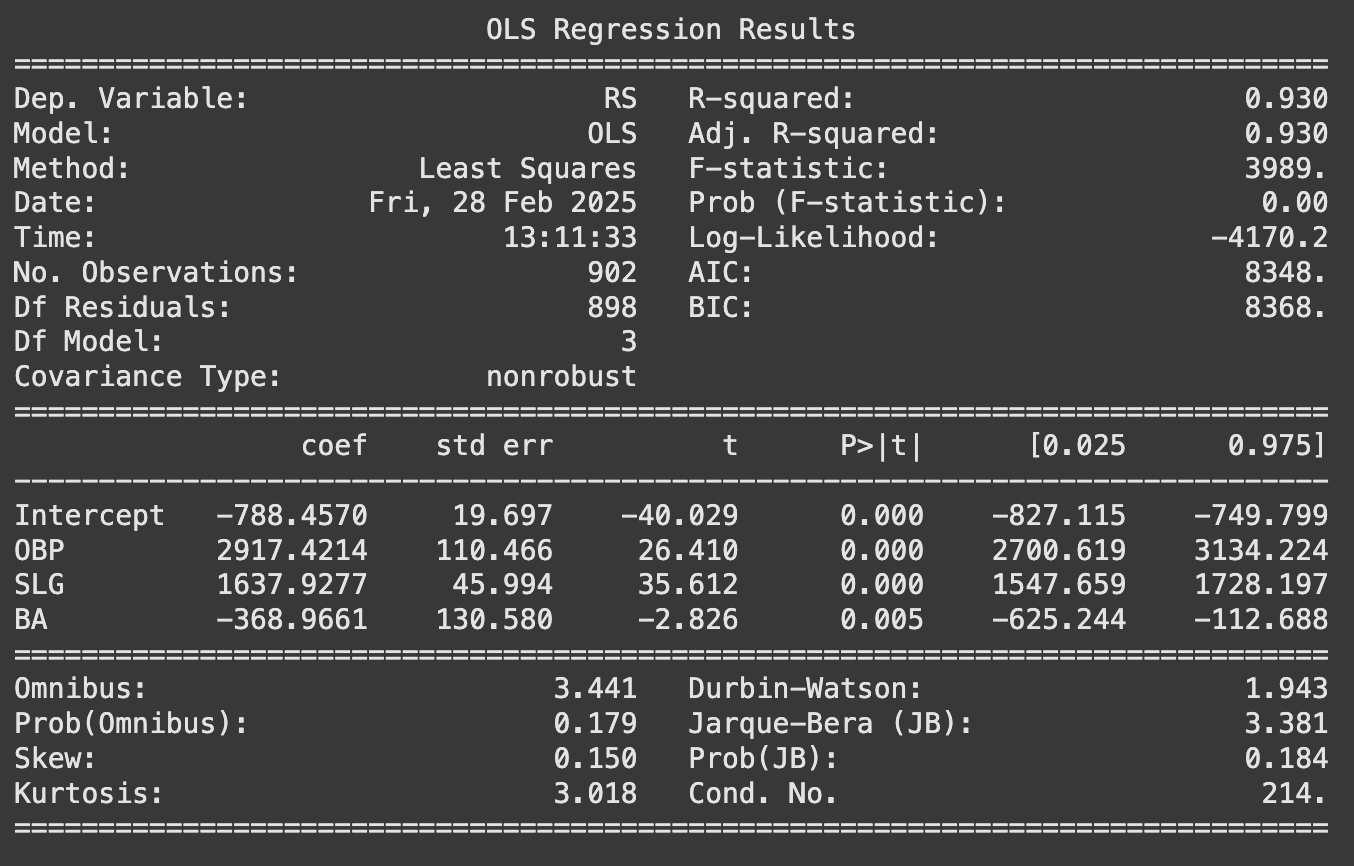

**Figure 10**: OLS regression summary: Runs Scored as a function of OBP, SLG, and BA

The regression results tell us a very similar story, with an *Adjusted R-squared* value of 0.930, and the OBP and SLG with positive coefficients. Although the batting average has historically been one of the most cited statistics in baseball, it has a negative correlation with runs scored in our model. One reason might be that OBP already captures that signal from the data, and BA adds redundant or even misleading information to the model. The negative coefficient for BA, holding OBP and SLG equal, suggests that a higher batting average is associated with less effective run production, even though the *p-value* of batting average is statistically significant with a score of 0.005. More importantly, the inclusion of batting average as a predictor variable does not add any improvement in terms of forecasting to the model, as the *Adjusted R-squared* remains relatively unchanged compared to the previous model version. Let’s switch to the other side of the plate and evaluate the team’s defensive efficiency by analyzing the inverse of what we just did.

We will shift our perspective from the offensive side of the diamond to the
defensive end. Specifically, our goal is to model Runs Allowed (RA) using the
opponent’s on-base percentage (OOBP) and slugging percentage (OSLG). These
two statistics capture how often opposing teams reach base and the amount
of power they generate when they do so. They are a mirror of OBP and SLG,
but from the opponent’s perspective. To accomplish this, we will rerun our
already familiar multiple regression model using OOBP and OSLG as the predictor
variables and Runs Allowed (RA) as the response variable.

In [ ]:
# Regression model
ra_model = smf.ols('RA ~ OOBP + OSLG', data=moneyball).fit()
print(ra_model.summary())

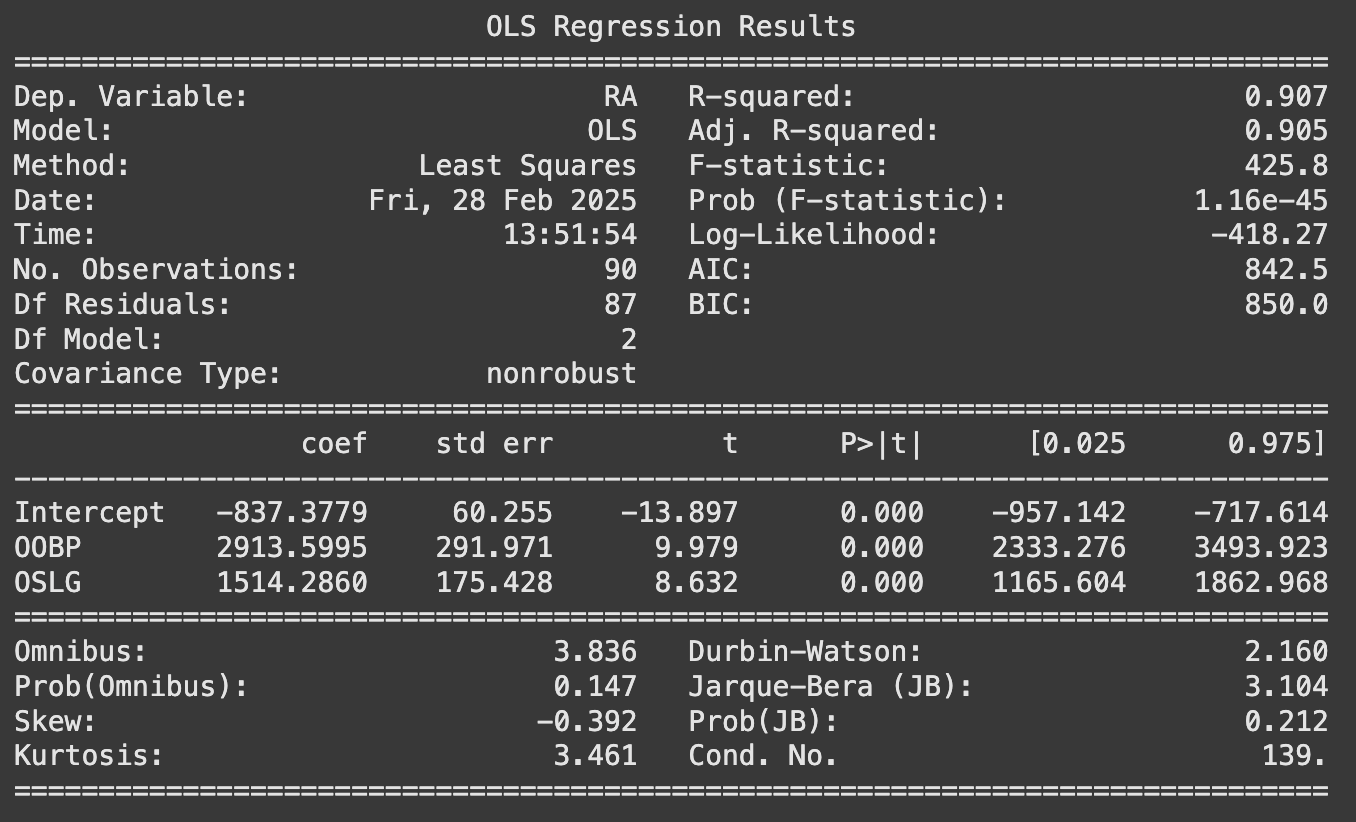

**Figure 11**: OLS regression summary: Runs Allowed as a function of OOBP, OSLG

In the regression results, the Adjusted R-squared scores 0.905, which means OOBP and OSLG explain around 90.5% of the variance in the number of runs allowed for any given team. Both variables score p-values below 0.005, which makes them statistically significant. Now, let’s review the coefficients for both variables. The OOBP coefficient sits at 2913.60. This coefficient tells us that, holding OSLG constant, a 0.010 increase in opponent OBP, or a 1% rise in how often opposing hitters get on base, is associated with approximately 29.14 more runs allowed.

$2913.60 \times 0.010 = 29.14$

Let’s recall our first two models, where we established that around ten runs equal one win. From this perspective, that would mean nearly three extra losses over a season. Similarly, the coefficient for OSLG of 1514.29 with an increase of 0.010 would mean 15.14 runs allowed.

$1514.29 \times 0.010 = 15.14$

The effect in allowed runs is more negligible in OSLG than in OOBP, but still it is substantial. From this analysis, we can derive that limiting base runners is even more important than restricting power when it comes to reducing runs scored. Up to this point, we have examined the anatomy of offensive and defensive efficiency using linear regression models. In the next section, we will take a step further by using these models to make predictions on unseen data. In any baseball or sports analytics endeavor, it is crucial to validate our assumptions and models against real-world and unseen data. Without validation on new data, even the most elegant models risk being nothing more than theoretical exercises.

## Projecting a Winning Season: Forecasting the 2002 Oakland A’s

In this section, we will demonstrate how to apply our regression models of runs scored (RS), runs allowed (RA), run differential (RD), and total wins (W) to estimate team performance using unseen data. To accomplish this, we will
simulate the 2002 season for the Oakland A’s — the team at the heart of
the Moneyball story. Let’s not forget that when we created our `(moneyball)`
DataFrame, we excluded the 2002 season when we filtered it this way `moneyball
= baseball[baseball[’Year’] < 2002].copy()`. This means that we did not
include the 2002 season in our model’s training data. Hence, using the predicted
offensive and defensive statistics from Moneyball, we input the A’s estimated
team metrics at the beginning of the season note that these metrics differ from
end-of-season values recorded in our dataset:

In [ ]:
# Values from Moneyball (predicted 2002 team stats)
obp_2002 = 0.339
slg_2002 = 0.430
oobp_2002 = 0.307
oslg_2002 = 0.373

With these numbers embedded as variables, we can proceed to input them into
our previously trained models.

In [ ]:
# Predict RS and RA
predicted_RS = rs_model.params['Intercept'] + rs_model.params['OBP']*obp_2002 + rs_model.params['SLG']*slg_2002
predicted_RA = ra_model.params['Intercept'] + ra_model.params['OOBP']*oobp_2002 + ra_model.params['OSLG']*oslg_2002
predicted_RD = predicted_RS - predicted_RA
predicted_W = wins_model.params['Intercept'] + wins_model.params['RD']*predicted_RD

Note that for the first two lines of code above, we use the .params attribute
of our regression models to access the learned coefficients — including the
Intercept and the values for each independent variable. We then multiply
each coefficient (OBP, SLG, OOBP, and OSLG) by the corresponding observed value
from the 2002 season. That way, we can estimate the predicted runs scored
(`predicted RS`) and runs allowed (`predicted RA`) values that in the third line
of code help us to derive the predicted run differential (`predicted RD`). Finally, in the last line of code, we call once again the learned `Intercept` and `RD` (Run Differencial) coefficient from our wins model. By multiplying the run differential we just estimated (predicted RD) by its corresponding coefficient and then adding the intercept, we are applying the regression equation to calculate how many games the 2002 Oakland A’s would be expected to win.

The model predicts the 2002 Oakland A’s would score around 805 runs, allow
621 runs, and end with a run differential of about +183, leading to an estimated
100.2 wins. Now, let’s compare that to what actually happened in that season:

| Team | Year |  RS |  RA |  W  | RD  |
|------|------|-----|-----|-----|-----|
| OAK  | 2002 | 800 | 654 | 103 | 146 |

**Table 1**: Oakland Athletics 2002 Season Statistics

The results are remarkable! For the 2002 season, the Oakland A’s scored 800
runs — just five less than predicted — and allowed 654 runs, which was 33
more than our model anticipated. This resulted in a run differential of +146,
falling 37 runs short of the expected figure. Despite this, the team exceeded
expectations in terms of wins, finishing with 103 victories, 2.8 wins more than
predicted. With just a few key inputs and regression models based on historical
data, we were able to confidently forecast a team’s season with impeccable
precision. In 2002, this predictive power allowed the A’s front office to build
a competitive roster despite their budget constraints, identifying undervalued
players and assembling a team designed not just to compete, but to win. But
this raises a crucial question for any front office: How much winning is enough?
In the next section, we shift our focus from performance forecasting to playoff
qualification, using historical data to estimate the win threshold required to
secure a postseason berth.

## Playoff Threshold: How Many Wins Are Enough?

In this section, our goal is to determine how many wins a team needs to qualify for the postseason. Ultimately, winning a lot of games is meaningless if, as a team, you do not get a shot at winning the World Series. The previous sections helped us understand how performance metrics translate into wins. Here, we address a different, yet equally strategic, question: What is the cut-off point for success? This section serves as a reminder that not every baseball and sports analytics problem requires the use of sophisticated modeling, algorithms, or machine learning; sometimes the answer lies in an intuitive and structured approach. First, we need to create two universes, one for teams that made the playoffs and one for those that did not; here is where the column Playoffs column in our dataset comes into action. We store those universes in the `playoff_teams` and `non_playoff_teams` variables.



In [ ]:
# Calculate how many wins needed to make playoffs

# Filter data for teams that made and didn't make the playoffs
playoff_teams = baseball[baseball['Playoffs'] == 1]
non_playoff_teams = baseball[baseball['Playoffs'] == 0]

Once we create both universes, we calculate the minimum, average, and maxi-
mum number of wins among playoff teams, and also identify the team with the
most wins that still missed the postseason.

In [ ]:
# Calculate the minimum, average, and maximum number of wins for playoff teams
min_wins_playoff = playoff_teams['W'].min()
average_wins_playoff = playoff_teams['W'].mean()
max_wins_playoff = playoff_teams['W'].max()

# Calculate the corresponding stats for non-playoff teams
max_wins_non_playoff = non_playoff_teams['W'].max()

print("Playoff Wins Analysis:")
print(f"Minimum Wins for Playoff Teams: {min_wins_playoff}")
print(f"Average Wins for Playoff Teams: {average_wins_playoff:.2f}")
print(f"Maximum Wins for Playoff Teams: {max_wins_playoff}")
print(f"Maximum Wins for Non-Playoff Teams: {max_wins_non_playoff}")

# Determine a possible win threshold to qualify for playoffs
win_threshold = max_wins_non_playoff + 1
print(f"Suggested Win Threshold for Playoff Qualification: {win_threshold}")

Playoff Wins Analysis:
Minimum Wins for Playoff Teams: 82
Average Wins for Playoff Teams: 95.12
Maximum Wins for Playoff Teams: 116
Maximum Wins for Non-Playoff Teams: 103
Suggested Win Threshold for Playoff Qualification: 104


From there, we print the data for the minimum, average, and maximum number
of wins among playoff teams and propose that the win threshold be one more win
than the most successful team that failed to make the playoffs. For example,
if the most wins by a non-playoff team is 103, then aiming for at least 104
wins becomes a realistic benchmark for postseason qualification, and data and
a large sample size back this. The 104 wins threshold is a reasonable figure for
a postseason berth, but such an approach just ”ballparks” the number. Let’s
attempt to come up with a more refined answer. Visually understanding data
patterns can often reveal trends that raw numbers alone may neglect. Let’s plot
team wins across all seasons in the dataset, color-coded by whether or not the
team made the playoffs, and observe what would be the ideal sweet spot of wins
for the playoff cutoff.

In [ ]:
# Plot wins vs playoff status with all seasons for a single team in a row
plt.figure(figsize=(14, 10))

# Scatter plot for wins vs playoff status
plt.scatter(moneyball['W'], moneyball['Team'],
            c=moneyball['Playoffs'].apply(lambda x: 'green' if x == 1 else 'red'))

plt.title('Wins vs Playoff Status by Team Over Seasons')
plt.xlabel('Wins')
plt.ylabel('Teams (Numbered)')
plt.legend(['Green = Made Playoffs, Red = Did Not Make Playoffs'])
plt.show()

# Visually inspect plot. Note that 95 is a good cutoff.

The code above will generate a scatter plot where each dot represents a team-
season combination:

The code above will generate a scatter plot where each dot represents a team-season combination:

* Green dots indicate seasons when a team made the playoffs.
* Red dots represent seasons when a team did not make the playoffs.
* Each team’s number of wins on the x-axis.
* Each team name is abbreviated on the y-axis.

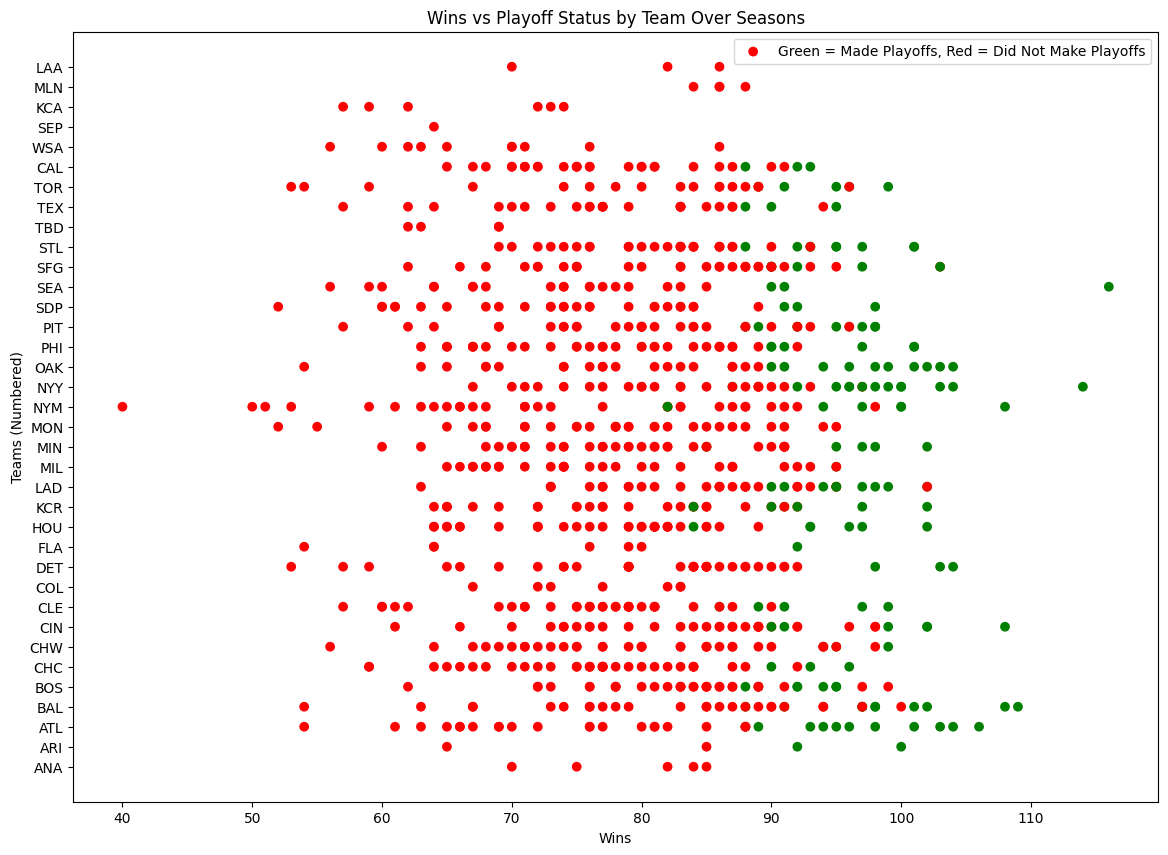

**Figure 12**: Wins vs playoff status for all team-seasons

We can visually identify clusters and thresholds that frequently separate playoff teams from non-playoff teams. From this visual inspection, one key insight becomes clear: 95 wins appear to be a reliable informal threshold. This is a good reminder to always, when possible, visualize your data as it might help spot inefficiencies in your approach or hidden insights. Of course, factors such as rule changes, divisional alignment, and league structure all play a role, and more sophisticated models could certainly refine this estimate.

Now, let’s switch to a more machine-learning-driven approach to this problem. So far, we have attempted to estimate the playoff berth cutoff relying solely on the data. This time, we will take a different approach by using a Decision Tree Classifier. Let’s start by importing the necessary libraries and creating the features and target variables.

In [ ]:
# Calculate number of wins needed to make playoffs using a decision tree of depth = 1
# Result: 90 and above wins is enough

from sklearn.tree import DecisionTreeClassifier, plot_tree

# Prepare features (W) and target variable (Playoffs)
X = moneyball[['W']]
y = moneyball['Playoffs']

We start by importing the `DecisionTreeClassifier` from the `sklearn.tree`
module. Then, we create the `X` variable, which in this case is the number of wins (`’W’`) column, and the `y` variable, or the target variable, as the `’Playoffs’` column. From there, we proceed to fit the model to the data.

In [ ]:
# Create the decision tree model
model = DecisionTreeClassifier(max_depth=1, random_state=42)
model.fit(X, y)

We set the max depth parameter to 1, meaning the model will only create a
single decision point or rule, effectively forming a decision stump. This ensures interpretability and answers a very simple question: Is there a specific win threshold that separates playoff and non-playoff teams? The random state parameter and its value 42 ensure the reproducibility of the results. Finally, we plot the results with a plot tree for straightforward interpretation of the results

In [ ]:
# Plot the decision tree
plt.figure(figsize=(10, 6))
plot_tree(model, feature_names=['Wins'], class_names=['No Playoffs', 'Playoffs'], filled=True)
plt.title('Decision Tree for Predicting Playoffs Based on Wins')
plt.show()

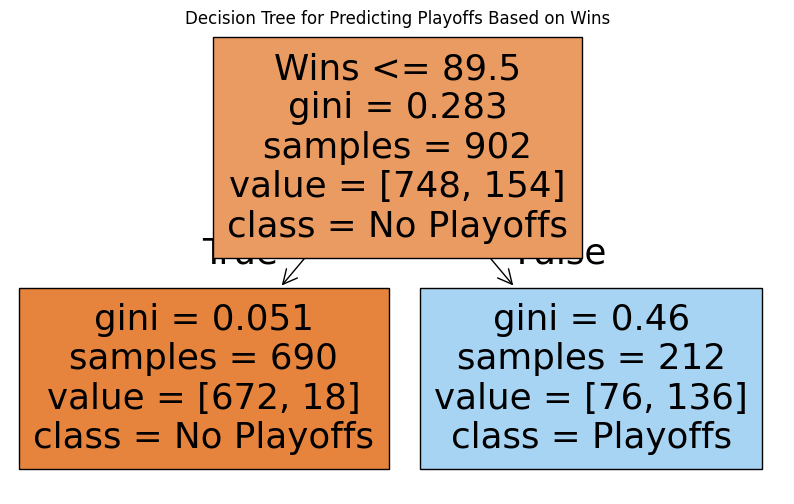

**Figure 13**: Decision Tree for Predicting Playoffs Based on Wins

The rectangle at the top is known as the root node. Let’s interpret their results step by step:

* Condition: Wins ≤ 89.5. This means that our decision tree has chosen 89.5
wins as the optimal threshold to split the dataset into two classification
universes.
* Gini = 0.283. This is the Gini impurity⁶, a measure of how ”mixed” the
classes are. A Gini of 0 means all samples belong to one class, while a
higher value indicates a more even mix.
* Samples = 902. The total number of teams analyzed.
* Value = [748, 154]. This means 748 of the 902 teams did not make the
playoffs (class 0), while 154 did (class 1).
* Class = No Playoffs. Since the majority of samples in this node did not
make the playoffs, this is the predicted class.

⁶LearnDataSci. Gini Impurity - Glossary Entry, LearnDataSci.com. Retrieved from https://www.learndatasci.com/glossary/gini-impurity/

Let’s evaluate the information provided in the left child node:

* True: Wins ≤ 89.5.
* Gini = 0.051. Very low impurity, meaning this group is mainly composed
of teams that did not make the playoffs.
* Samples = 690. The total number of teams analyzed.
* Value = [672, 18]. Only 18 of these teams out of 690 made the playoffs.
* Class = No Playoffs. As expected, this node classifies teams as non-playoff teams.

Now the right child node:
* False: Wins > 89.5
* Gini = 0.46. A much higher impurity, which translates to this group being
more balanced.
* Samples = 212
* Value = [76, 136]. Here, 136 teams made the playoffs, while 76 did not.
* Class = Playoffs: Despite some misclassifications, this node classifies teams
as part of the Playoffs class.

In essence, teams with 90 or more wins are very likely to make the playoffs.
Teams with 89 or fewer wins do very rarely. To refine this cutoff and quantify
playoff chances more precisely, let’s compute the probability of making the playoffs based on historical win totals between 80 and 100, as we currently know or presume that the optimal number falls within that range.


In [ ]:
# Create table that shows probability of making wins as function of playoffs

# Initialize a list to store the results
results = []

We first initialize an empty list called results, where we will store the win
thresholds and the corresponding probability of making the playoffs.

In [ ]:
# Calculate the probability of making playoffs for wins from 80 to 100
for wins in range(80, 101):
    # Filter the data for teams with the current win total or greater
    subset = moneyball[moneyball['W'] >= wins]

    # Calculate the probability of making playoffs
    if not subset.empty:
        probability = subset['Playoffs'].mean()  # Mean will give the probability
    else:
        probability = 0.0  # No teams with this win total

    # Append the result
    results.append({'Wins': wins, 'Probability of Playoffs': probability})


Next, we proceed to loop through every possible win total from 80 to 100
with the line `for wins in range(80, 101`. Inside the loop, we filter the
dataset for teams that won at least that many games using the following line
of code: `subset = moneyball[moneyball[’W’] >= wins]`. For each subset,
we calculate the average of the `Playoffs` column. Taking the mean gives
us the proportion of teams that made the playoffs, that is, the probability
(`probability = subset[’Playoffs’].mean()`), otherwise, we assign a value
of 0.0 (`probability = 0.0`). Finally, we store the results using the `.append`
method with the line of code `results.append(’Wins’: wins, ’Probability
of Playoffs’: probability)`. It is essential to note that we have stored the
results in a dictionary format, where each key (`wins`) corresponds to a single
value (`probability`). For better readability, we convert the list of dictionaries into a DataFrame.

In [ ]:
# Create a DataFrame from the results
probability_df = pd.DataFrame(results)

# Display the DataFrame
print(probability_df)

    Wins  Probability of Playoffs
0     80                 0.308000
1     81                 0.324895
2     82                 0.345291
3     83                 0.360000
4     84                 0.392308
5     85                 0.419444
6     86                 0.455927
7     87                 0.501684
8     88                 0.550186
9     89                 0.589958
10    90                 0.641509
11    91                 0.677596
12    92                 0.721519
13    93                 0.762963
14    94                 0.786885
15    95                 0.818182
16    96                 0.833333
17    97                 0.848101
18    98                 0.870968
19    99                 0.914894
20   100                 0.923077


Let’s dig into the results. At 80 wins, a team has roughly a 30% chance of
making the playoffs. At 90 wins, that probability increases to 64%. At 95 wins
and beyond, the likelihood jumps past 90%! Together, the Decision Tree and
Win-Threshold Probability analyses reinforce the practical insight that, while
the postseason threshold varies from year to year, a range of 90 to 95 wins is
the ”sweet spot” that most teams should aim for. This benchmark helps teams
set realistic performance targets and assess whether their current trajectory
provides a good chance of making the playoffs.

# Concluding Remarks

In this chapter, we have briefly revisited the inception of the Moneyball philosophy and, perhaps more importantly, we performed practical baseball analytics by analyzing an extensive historical dataset of baseball statistics. This allowed us to understand, through real-world problems and scenarios, how baseball analytics can help any team gain an edge over its competition. A second-order effect of this chapter might be the gain in knowledge in terms of statistical and machine learning modeling that helps to forecast future performance, eliminate chance, and inform strategic decisions.

We analyze the relationship between run differential and wins throughout
this chapter, demonstrating how a simple yet powerful linear regression model
can offer clarity into team performance. Then, Bill James’ Pythagorean Expectation was explored, a pioneering model that introduced a new lens for understanding team success beyond traditional statistics. Furthermore, we developed layered models that link offensive (OBP, SLG) and defensive (OOBP, OSLG) statistics to run production and prevention. Finally, we evaluated a real-world application using the 2002 Oakland A’s season for a compelling case study, and we delved into analyzing postseason wins thresholds using empirical, machine learning, and probabilistic approaches.

Today, we live in a world shaped by data, and sports analytics offers different
insights into sports that have long been governed by intuition, such as baseball. This chapter aimed not only to serve as an introduction to the analytical tools behind baseball decision-making but also to remind the reader of how thinking outside the box can create an edge. Whether you are part of a front office, a coach, an analyst, or simply a fan, these methods underlie a fundamental truth: winning in modern baseball is no longer just about talent, it is about understanding where value hides and how to extract the most from every run, every game, and every player.